In [1]:
import os
import stella
import starry
import numpy as np
from tqdm import tqdm_notebook
from astropy import units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.timeseries import LombScargle
from sklearn.metrics import precision_recall_curve
from lightkurve.lightcurve import LightCurve as LC

from stella.utils import break_rest, do_the_shuffle, split_data

starry.config.lazy = False
starry.config.quiet = True

//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1)

# Starry spot models

In [2]:
step = int((22*u.day).to(u.min).value/2)
time = np.linspace(0,22,step) * u.day
time = time.value

### Create Starry Models

In [8]:
spot_table = Table(names=['model', 'inc', 'Prot', 'nspots', 'lat', 
                          'lon', 'intensity', 'spotsize'],
                   dtype=[np.int64, np.float64, np.float64, np.int64, 
                          np.ndarray, np.ndarray, np.ndarray, np.ndarray])
nmodels = 3000
#models = np.zeros((nmodels, len(time)))

fn = 'starry_models/spot_model_{0:04d}.npy'

for m in tqdm_notebook(range(300)):

    inc_rad = np.random.uniform(0, 1, 1)[0] 
    inc = np.arccos(inc_rad) * u.radian # inclination

    # TWEAK LIMB DARKENING
    u1 = 0.5
    alpha = 0.02  # differential rotation shear
    P = np.random.uniform(0.2,8,1)[0]  # equatorial period

    # Generate a 10th degree map with linear limb darkening
    #np.random.seed(0)
    map = starry.Map(10, 1)
    map[1] = 0.5
    omega_eq = 360.0 / P
    true_flux = np.zeros_like(time)
    res = 300

    howmany = np.random.randint(1,10,1)[0]
    # Generate light curves for three spots
    sigma       = np.random.uniform(0.001, 0.1, howmany) # spot size
    true_lats   = np.random.uniform(-90, 90,howmany)
    true_lons   = np.random.uniform(-180,80,howmany)
    intensities = np.random.uniform(-3.5, -1.2, howmany)

    spot_table.add_row([m, inc, P, howmany, true_lats, true_lons, intensities, sigma])
    
    model_dict = {}
    model_dict['inc'] = inc
    model_dict['Prot'] = P
    model_dict['nspots'] = howmany
    model_dict['lat'] = true_lats
    model_dict['lon'] = true_lons
    model_dict['intensities'] = intensities
    model_dict['spotsize'] = sigma

    for i in range(howmany):
        lat = true_lats[i]
        lon = true_lons[i]
        intensity = intensities[i]

        # The angular velocity at the current latitude, computed
        # from the equation for linear differential rotation
        omega = omega_eq * (1 - alpha * np.sin(lat * np.pi / 180.0) ** 2)

        # Reset the map coefficients & add a new spot
        map.reset()
        map.inc = inc
        map[1] = u1
        map.add_spot(intensity=intensity, sigma=sigma[i], lat=lat, lon=lon)

        # Add to the flux
        true_flux += map.flux(theta=omega * time)

    # Normalize and add a little bit of noise
    flux = true_flux / np.nanmedian(true_flux)
    #flux += flux_err * np.random.randn(len(time))
    #models[m] = flux

    
    np.save(fn.format(m), [model_dict, flux])

### Load Models

In [16]:
model_dir = 'starry_models/'
model_fns = os.listdir(model_dir)
models = np.zeros((len(model_fns), len(time)))

spot_table = Table(names=['model', 'inc', 'Prot', 'nspots', 'lat', 
                          'lon', 'intensity', 'spotsize'],
                   dtype=[np.int64, np.float64, np.float64, np.int64, 
                          np.ndarray, np.ndarray, np.ndarray, np.ndarray])

for i in range(len(model_fns)):
    data = np.load(os.path.join(model_dir, model_fns[i]), allow_pickle=True)
    models[i] = data[1]
    dict_values = [i]
    for key in list(data[0].keys()):
        dict_values.append(data[0][key])
    spot_table.add_row(dict_values)

## Importing TOIs

In [18]:
table = Table.read('tois/tois_09032020.txt', format='csv')
files = os.listdir('tois')
files = np.sort([os.path.join('tois', i) for i in files if i.endswith('.npy')])

In [40]:
ss = 24000000

CADENCES = 800 # STILL DEBATING THIS VALUE

REFORMAT_FLUX = np.zeros((ss, CADENCES))
LABELS = np.zeros(ss, dtype=int)

IDS = np.zeros(ss, dtype=int)
MODELS = np.zeros(ss, dtype=int)
x = 0

min_period = np.nanmin(pers[per_cadences>CADENCES+100].value)

for i in tqdm_notebook(range(len(files))):

    # OPENS NUMPY FILE OF LIGHT CURVE
    data = np.load(files[i])

    q = data[5] == 0
    tic = int(files[i].split('/')[-1].split('_')[0][3:])
    subtable = table[table['TIC ID']==tic]

    # SELECTING STARS WITH: 1 CANDIDATE, PLANET SNR >= 50, PERIOD > 800 CADENCES
    if ( (len(subtable['Sectors']) == 1) and (subtable['Planet SNR'] >= 50) and
         (subtable['Period (days)'] > min_period) ):
    
        t0 = subtable['Epoch (BJD)'] - 2457000
        period = subtable['Period (days)']

        # FIND ALL TRANSITS IN THE LIGHT CURVES
        transits = np.arange(-20,150,1)*period + t0

        # RANDOMLY CHOSE 50 MODELS FROM DIRECTORY TO INJECT
        # ALL EXAMPLES HAVE STARRY MODELS IN THEM (MAYBE WANT TO CONSIDER INCLUDING JUST
        #                                          THE TESS LIGHT CURVE?)
        for m in np.random.randint(0,len(models),50):
            prot = spot_table[m]['Prot']
            
            # INTERPOLATE MODEL ONTO LIGHT CURVE GRID
            interp = interp1d(np.linspace(data[0][q][0]-0.5, 
                                          data[0][q][-1]+0.5, 
                                          len(models[m])), 
                              models[m])
            
            lk = LC(data[0][q],
                    data[1][q], 
                    flux_err=np.zeros(len(data[1][q]))).normalize().remove_nans()
            lk.flux *= interp(lk.time)

            transits = transits[(transits<=lk.time[-1]) & (transits>=lk.time[0])]
            remove_inds = np.array([])

            # CREATES THE POSITIVE TRAINING SET
            for t in transits:
                inds = np.arange(np.where(lk.time>=t)[0][0]-CADENCES/2,
                                 np.where(lk.time>=t)[0][0]+CADENCES/2, 1, dtype=int)
                
                # REMOVES TRANSITS THAT CAN'T BE CENTERED
                if len(np.where(inds < 0)[0]) > 0:
                    remove_inds = np.append(remove_inds, inds)
                    
                elif len(np.where(inds > len(lk.time)-1)[0]) > 0:
                    remove_inds = np.append(remove_inds, inds)
                    
                else:
                    med_transit = np.nanmedian(lk.flux[inds][int(len(inds)/2)-10:
                                                             int(len(inds)/2)+10])
                    if med_transit < np.nanmedian(lk.flux[inds]):
                        REFORMAT_FLUX[x] = lk.flux[inds]
                        LABELS[x]= 1
                        IDS[x] = tic
                        MODELS[x] = m
                                                
                        x += 1
                    remove_inds = np.append(remove_inds, inds)

            # REMOVES INDICES WHERE THERE ARE TRANSITS FROM THE LIGHT CURVE
            cleaned_flux = np.delete(lk.flux, remove_inds)
            cleaned_time = np.delete(lk.time, remove_inds)
            cleaned_err  = np.delete(lk.flux_err, remove_inds)

            t, f, e = break_rest(cleaned_time, cleaned_flux, cleaned_err, cadences=CADENCES)
            
            # CREATES NEGATIVE EXAMPLES
            for j in range(len(t)):
                REFORMAT_FLUX[x] = f[j]                
                LABELS[x] = 0
                IDS[x] = tic
                MODELS[x] = m
                x += 1

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: in the future negative indices will not be ignored by `numpy.d

In [41]:
# REMOVES ADDITIONAL ARRAYS IN INITIAL ARRAY SETUP
REFORMAT_FLUX = np.delete(REFORMAT_FLUX, np.arange(x,ss,1,dtype=int),axis=0)
LABELS = np.delete(LABELS, np.arange(x,ss,1,dtype=int))

REFORMAT_PERIOD = np.delete(REFORMAT_PERIOD, np.arange(x,ss,1,dtype=int),axis=0)
LABELS_PERIOD = np.delete(LABELS_PERIOD, np.arange(x,ss,1,dtype=int))

IDS = np.delete(IDS, np.arange(x, ss, 1, dtype=int))
MODELS = np.delete(MODELS, np.arange(x, ss, 1, dtype=int))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


## Shuffle & Split the training set

In [42]:
# 0.1 = SET THE FRACTION OF TRUE NEGATIVES TO REMOVE TO IMPROVE CLASS IMBALANCE
SHUFFLE_IDS, SHUFFLE_MATRIX, SHUFFLE_LABELS, SHUFFLE_MODELS = do_the_shuffle(REFORMAT_FLUX, 
                                                                            LABELS, 
                                                                            MODELS,
                                                                            IDS, 0.1)

162886 positive classes (flare)
188640 negative classes (no flare)
86.0% class imbalance



x_* = data

y_* = label

In [51]:
x_train, y_train, x_val, y_val, val_ids, val_other, x_test, y_test, test_ids, test_other = split_data(SHUFFLE_LABELS,
                                                                                                      SHUFFLE_MATRIX,
                                                                                                      SHUFFLE_IDS,
                                                                                                      np.zeros(len(LABELS)),
                                                                                                      training=0.80,
                                                                                                      validation=0.90)

In [54]:
np.save('training_set_data.npy', x_train)
np.save('training_set_labels.npy', y_train)
np.save('validation_set.npy', [x_val, y_train, val_ids, val_other])
np.save('test_set.npy', [x_test, y_test, test_ids, test_other])

## Looking at the *TRAINING* set
(Don't touch the test set)

In [38]:
ind_ye = np.where(y_train==1)[0]
ind_no = np.where(y_train==0)[0]

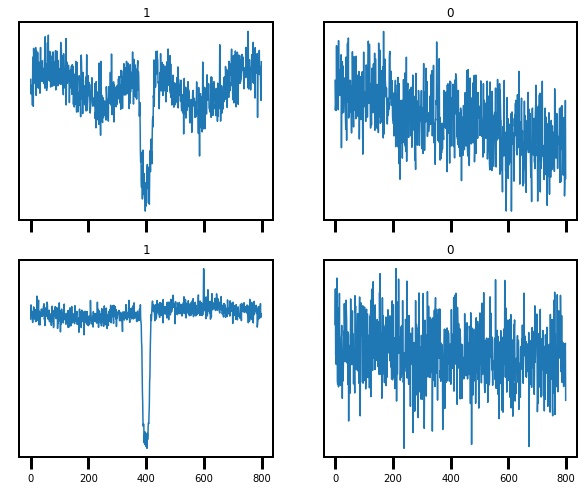

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(10,8),
                                             sharex=True)
ax1.plot(x_train[ind_ye[62]])
ax1.set_title(y_train[ind_ye[67]])

ax2.plot(x_train[ind_no[68]])
ax2.set_title(y_train[ind_no[68]])

ax3.plot(x_train[ind_ye[70]])
ax3.set_title(y_train[ind_ye[70]])

ax4.plot(x_train[ind_no[70]])
ax4.set_title(y_train[ind_no[70]])

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([]);

#plt.savefig('training_set.png', dpi=200, rasterize=True)

## Creating da net (same format as stella)

In [86]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.3.0'

In [87]:
np.random.seed(0)
tf.random.set_seed(0)

keras.backend.clear_session()

model = keras.models.Sequential()

filter1 = 16
filter2 = 64
dense = 32
dropout = 0.1
ks = 7

model.add(tf.keras.layers.Conv1D(filters=filter1, kernel_size=ks,
                                 activation='relu', padding='same',
                                 input_shape=(CADENCES, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Conv1D(filters=filter2, kernel_size=int(ks/2),
                                 activation='relu', padding='same',
                                 input_shape=(CADENCES, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [88]:
model.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy', tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])

In [89]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 800, 16)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 400, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 400, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [90]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=64, 
                    shuffle=False,
                    validation_data=(x_val, y_val))

Epoch 1/50
4657/4657 [==============================] - 138s 30ms/step - loss: 0.4543 - accuracy: 0.7542 - precision: 0.9518 - recall: 0.4606 - val_loss: 0.8175 - val_accuracy: 0.5607 - val_precision: 0.8451 - val_recall: 0.0037
Epoch 2/50
4657/4657 [==============================] - 138s 30ms/step - loss: 0.1402 - accuracy: 0.9622 - precision: 0.9772 - recall: 0.9353 - val_loss: 0.8103 - val_accuracy: 0.5615 - val_precision: 0.8812 - val_recall: 0.0054
Epoch 3/50
4657/4657 [==============================] - 130s 28ms/step - loss: 0.1279 - accuracy: 0.9659 - precision: 0.9806 - recall: 0.9405 - val_loss: 0.8487 - val_accuracy: 0.5645 - val_precision: 0.9358 - val_recall: 0.0124
Epoch 4/50
4657/4657 [==============================] - 130s 28ms/step - loss: 0.1215 - accuracy: 0.9670 - precision: 0.9815 - recall: 0.9423 - val_loss: 0.4529 - val_accuracy: 0.7696 - val_precision: 0.9942 - val_recall: 0.4799
Epoch 5/50
4657/4657 [==============================] - 135s 29ms/step - loss: 0.117

Epoch 37/50
4657/4657 [==============================] - 130s 28ms/step - loss: 0.0799 - accuracy: 0.9777 - precision: 0.9904 - recall: 0.9583 - val_loss: 0.0616 - val_accuracy: 0.9831 - val_precision: 0.9969 - val_recall: 0.9647
Epoch 38/50
4657/4657 [==============================] - 135s 29ms/step - loss: 0.0779 - accuracy: 0.9781 - precision: 0.9907 - recall: 0.9588 - val_loss: 0.0690 - val_accuracy: 0.9781 - val_precision: 0.9974 - val_recall: 0.9527
Epoch 39/50
4657/4657 [==============================] - 133s 29ms/step - loss: 0.0762 - accuracy: 0.9786 - precision: 0.9908 - recall: 0.9600 - val_loss: 0.0670 - val_accuracy: 0.9802 - val_precision: 0.9981 - val_recall: 0.9569
Epoch 40/50
4657/4657 [==============================] - 137s 30ms/step - loss: 0.0760 - accuracy: 0.9787 - precision: 0.9910 - recall: 0.9600 - val_loss: 0.0764 - val_accuracy: 0.9774 - val_precision: 0.9940 - val_recall: 0.9544
Epoch 41/50
4657/4657 [==============================] - 139s 30ms/step - loss: 

Text(0.5, 0, 'epochs')

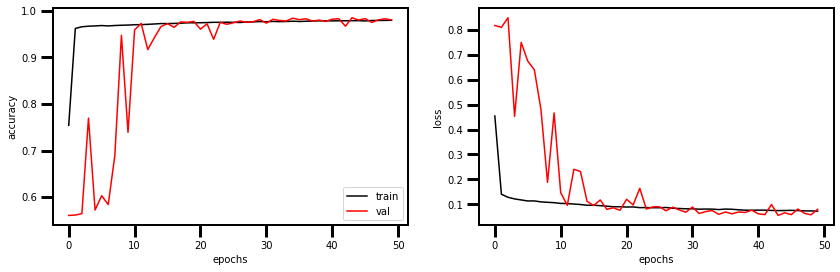

In [91]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4), sharex=True)

ax1.plot(history.epoch, history.history['accuracy'], 'k',
        label='train')
ax1.plot(history.epoch, history.history['val_accuracy'], 'r',
        label='val')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], 'k')
ax2.plot(history.epoch, history.history['val_loss'], 'r')
ax2.set_ylabel('loss')

ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')

#plt.savefig('test3_sample_models_different.png', dpi=200, rasterize=True)

In [92]:
val_pred = model.predict(x_val)
val_pred = np.reshape(val_pred, len(val_pred))

threshold = 0.75

rounded = np.copy(val_pred)
rounded[rounded>threshold] = 1
rounded[rounded<=threshold] = 0
rounded = np.array(rounded, dtype=int)

In [93]:
tp = np.unique(np.where((rounded==1) & (y_val==1))[0])
tn = np.unique(np.where((rounded==0) & (y_val==0))[0])

fp = np.unique(np.where((rounded==1) & (y_val==0))[0])
fn = np.unique(np.where((rounded==0) & (y_val==1))[0])

In [200]:
print("True positives:", len(tp)/len(rounded), len(y_val[y_val==1])/len(y_val))
print("True negatives:", len(tn)/len(rounded), len(y_val[y_val==0])/len(y_val))

True positives: 0.4205341564890619 0.4406119983894779
True negatives: 0.5574553751174339 0.559388001610522


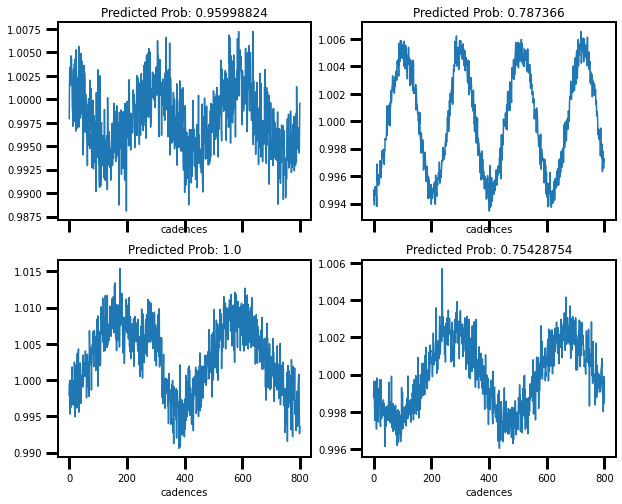

In [105]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex=True)
i = 60

for ax in axes.reshape(-1):
    ax.plot(x_val[fp[i]])
    ax.set_title('Predicted Prob: ' + str(val_pred[fp[i]]))
    
    if i > 7:
        ax.set_xlabel('cadences')
    i += 1
    
#plt.savefig('false_positives.png', dpi=200, rasterize=True)

In [100]:
prec, rec, _ = precision_recall_curve(y_val, val_pred)

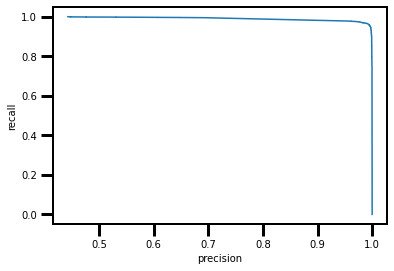

In [101]:
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall');